In [65]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
import shap
import optuna
from optuna import Trial
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv
/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [66]:
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

# Bring in additional data
df = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

In [67]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [68]:
train.drop(columns=['id', 'Surname', 'CustomerId'], inplace=True)
test.drop(columns=['id', 'Surname', 'CustomerId'], inplace=True)
train.shape

(165034, 11)

In [69]:
print(train.isnull().sum())

print(test.isnull().sum())
# no missings

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


In [70]:
df.shape

(10002, 14)

In [71]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [72]:
# As with the training and test data, will drop non-predictors
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [73]:
print(df.isnull().sum())
# Some missings that I will drop for now

CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64


In [74]:
df.dropna(inplace=True)

In [75]:
# Append all training data
train = pd.concat([train, df])

## EDA
Will consider target variable for numeric and categorical columns.

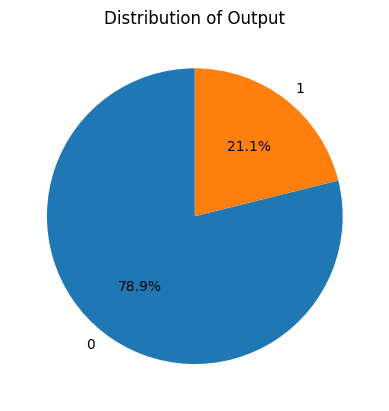

In [76]:
# Look at target variable
plt.pie(train['Exited'].value_counts().values, labels=np.unique(train['Exited']), autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Output')
plt.show()
# unbalanced class distribution so need to stratify

In [77]:
train.Exited.value_counts()

Exited
0    138073
1     36959
Name: count, dtype: int64

In [78]:
numeric_columns = train.select_dtypes(include='number').columns.tolist()
categorical_columns = train.select_dtypes(include='object').columns.tolist()
numeric_columns.remove('Exited')

In [79]:
def plot_distributions(df, columns, target_variable=None):

    # Determine the number of subplots required
    num_columns = len(columns)
    num_subplots = math.ceil(num_columns / 2)

    # Create subplots
    fig, axes = plt.subplots(num_subplots, 2, figsize=(12, 4 * num_subplots))
    axes = axes.flatten()

    # Plot distribution plots for each numeric column
    for i in range(num_columns):
        sns.histplot(data=df, x=columns[i], hue=target_variable, stat='percent', common_norm=False, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {columns[i]}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

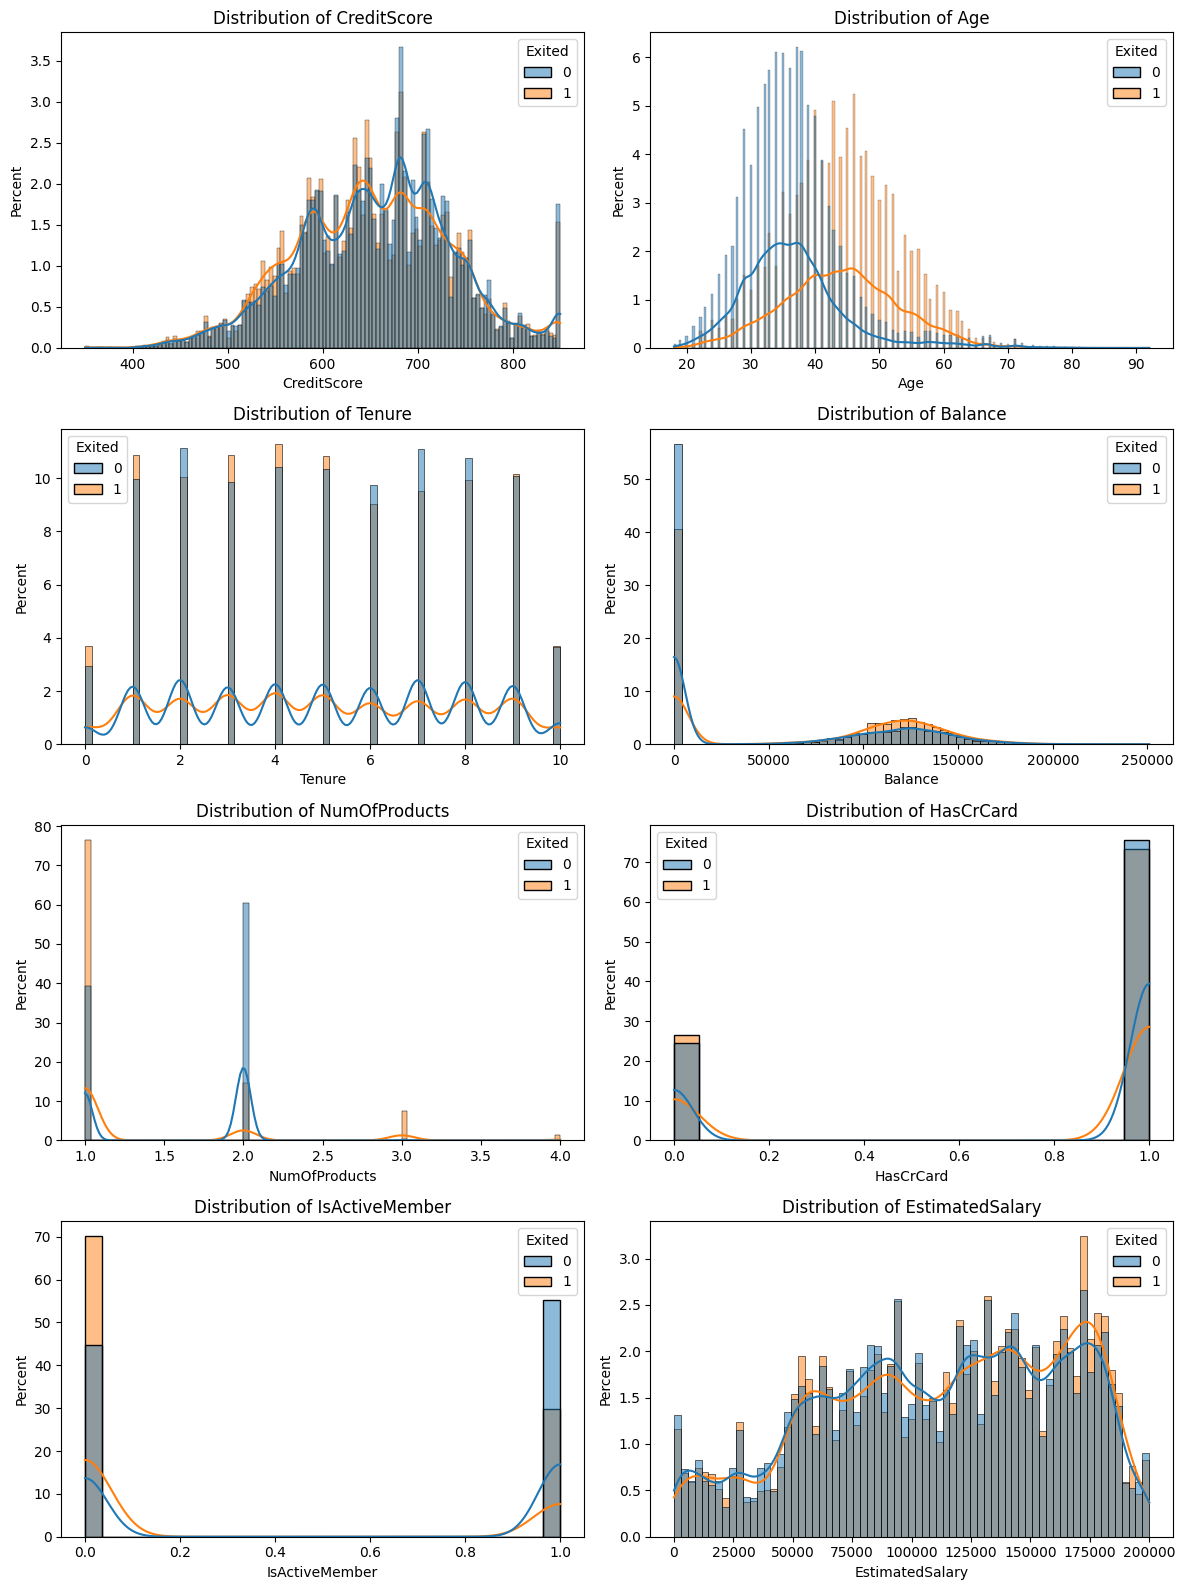

In [80]:
plot_distributions(train, numeric_columns, target_variable='Exited')

Additional variables appear to be categorical based on discrete distributions. For example: HasCrCard and IsActiveMember.

In [81]:
# Now look at categorical variables
def plot_categorical_distributions(df, categorical_columns, target_variable=None):

    # Determine the number of subplots required
    num_categorical_columns = len(categorical_columns)
    num_subplots = math.ceil(num_categorical_columns / 2)

    # Create subplots
    fig, axes = plt.subplots(num_subplots, 2, figsize=(12, 4 * num_subplots))
    axes = axes.flatten()

    # Plot bar plots for categorical columns
    for i in range(num_categorical_columns):
        sns.countplot(data=df, x=categorical_columns[i], hue=target_variable, ax=axes[i])
        axes[i].set_title(f'Distribution of {categorical_columns[i]}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

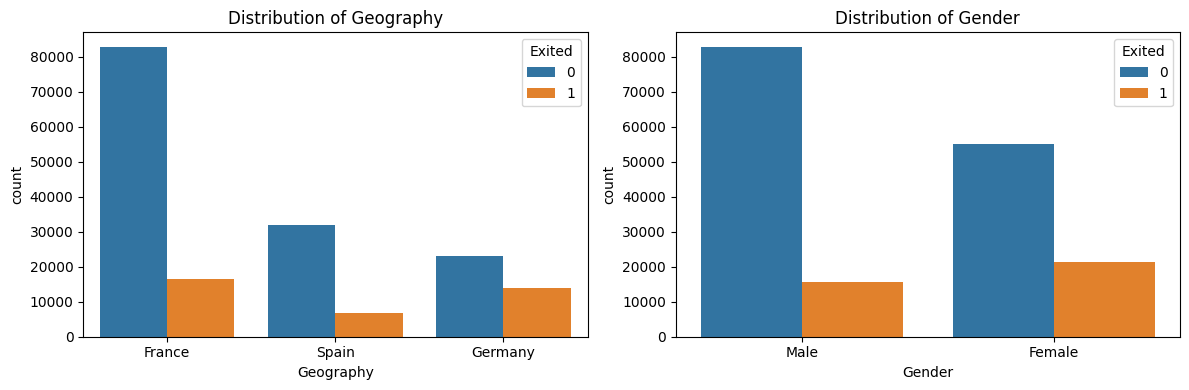

In [82]:
plot_categorical_distributions(train, categorical_columns, target_variable='Exited')

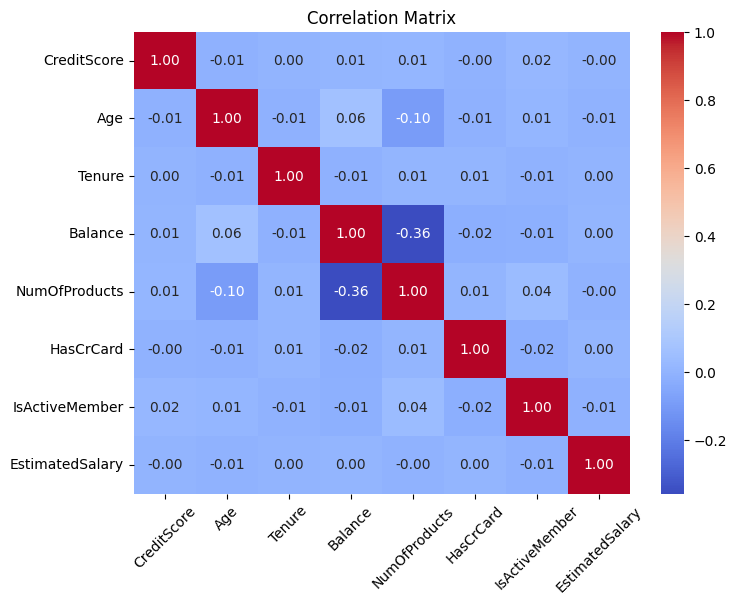

In [83]:
correlation_matrix = train.loc[:, numeric_columns].corr()

# Plot the correlation matrix with column labels
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})

# Add column labels
plt.xticks(np.arange(0.5, len(numeric_columns) + 0.5), numeric_columns, rotation=45)
plt.yticks(np.arange(0.5, len(numeric_columns) + 0.5), numeric_columns, rotation=0)

plt.title('Correlation Matrix')
plt.show()

In [84]:
categorical_columns.extend(['HasCrCard', 'IsActiveMember', 'NumOfProducts'])
numeric_columns.remove('HasCrCard')
numeric_columns.remove('IsActiveMember')
numeric_columns.remove('NumOfProducts')

In [85]:
# Create dummies of categorical variables
train = pd.get_dummies(train, columns=categorical_columns, drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=categorical_columns, drop_first=True, dtype=int)